## Import thư viện 

In [1]:
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Đọc dữ liệu đầu vào

In [2]:
df1 = pd.read_csv('raw data/Small_DS.csv')  
df1 = df1.drop(columns=['names','link','tag']) 
df1 = df1.drop_duplicates()
df1 = df1.reset_index(drop=True)
df1.head(10)

,price,brand,type,condition,preserve,storage,result,display,camera,pin,date,ram_storage
0,9.900.000 đ,apple,iphone 12 pro,đã sử dụng (chưa sửa chữa),đang cập nhật,128 gb,1,"6.7""",12MP,3687mAh,"Released 2020, November 13","128GB 6GB RAM, 256GB 6GB RAM, 512GB 6GB RAM"
1,1500000,samsung,galaxy a30,đã sử dụng (chưa sửa chữa),hết bảo hành,64.0 gb,0,"6.4""",16MP,4000mAh,"Released 2019, March","32GB 3GB RAM, 64GB 3GB RAM, 64GB 4GB RAM"
2,8.500.000 đ,apple,iphone 11 pro max,đã sử dụng (chưa sửa chữa),hết bảo hành,64.0 gb,0,"6.5""",12MP,3969mAh,"Released 2019, September 20","64GB 4GB RAM, 256GB 4GB RAM, 512GB 4GB RAM"
3,11.000.000 đ,apple,iphone 12 pro,đã sử dụng (chưa sửa chữa),đang cập nhật,128 gb,1,"6.7""",12MP,3687mAh,"Released 2020, November 13","128GB 6GB RAM, 256GB 6GB RAM, 512GB 6GB RAM"
4,16.900.000 đ,samsung,galaxy z fold3,đã sử dụng (chưa sửa chữa),còn bảo hành,256.0 gb,1,"7.6""",12MP,4400mAh,"Released 2021, August 27","256GB 12GB RAM, 512GB 12GB RAM"
5,1500000,apple,iphone 6s,đã sử dụng (chưa sửa chữa),còn bảo hành,64.0 gb,0,"4.7""",12MP,1715mAh,"Released 2015, September 25","16GB 2GB RAM, 32GB 2GB RAM, 64GB 2GB RAM, 128G..."
6,5.500.000 đ,apple,iphone xr,đã sử dụng (chưa sửa chữa),1 tháng,64 gb,0,"6.1""",12MP,2942mAh,"Released 2018, October 26","64GB 3GB RAM, 128GB 3GB RAM, 256GB 3GB RAM"
7,4.500.000 đ,apple,iphone xs,đã sử dụng (chưa sửa chữa),1 tháng,64 gb,0,"6.5""",12MP,3174mAh,"Released 2018, September 21","64GB 4GB RAM, 256GB 4GB RAM, 512GB 4GB RAM"
8,260.000 đ,apple,iphone 5,đã sử dụng (chưa sửa chữa),đang cập nhật,16.0 gb,0,"4.0""",8MP,1560mAh,"Released 2013, September 20","16GB 1GB RAM, 32GB 1GB RAM, 64GB 1GB RAM"
9,9200000,apple,iphone 11 pro max,đã sử dụng (chưa sửa chữa),hết bảo hành,64.0 gb,0,"6.5""",12MP,3969mAh,"Released 2019, September 20","64GB 4GB RAM, 256GB 4GB RAM, 512GB 4GB RAM"


### Các hàm xử lí dùng để làm sạch dữ liệu

Hàm tách ram_storage thành mảng gồm 2 phần tử là storage và ram

In [3]:
def split_ram_storage(value) : 
    if isinstance(value, str) : 
        pattern = r'\d+(?:GB|MB|TB)(?: \d+(?:\.\d+)?(?:GB|MB|TB))? RAM'
        value = re.findall(pattern, value)
    return value

Hàm chuyển đổi đơn vị MB và TB về GB

In [4]:
def convert_to_GB(value) : 
    if isinstance(value, str) : 
        value = re.sub(r'(\d+)MB', lambda m: str(int(m.group(1)) / 1024) + 'GB', value)
        value = re.sub(r'(\d+)TB', lambda m: str(int(m.group(1)) * 1024) + 'GB', value)
    return value

Hàm tách lấy số và bỏ đi đơn vị

In [5]:
def convert_ram_storage(value):
    # Tách lấy phần số đầu tiên và phần số thứ hai từ chuỗi
    # print(value)
    if isinstance(value, str) :
        matches = re.findall(r'(\d+\.?\d*)GB', value)
        if len(matches) == 2:
            return ' '.join(matches)
        else:
            return value

Hàm tách chỉ lấy phần số

In [6]:
def extract_number(value) : 
    if isinstance(value, str):
        pattern = r'\d+'
        numbers = re.findall(pattern, value)
        if numbers:
            return numbers[0]
    return None

Tạo dataframe mới lấy từ cột type và ram_storage để dễ xử lí chia tách ram và storage

In [7]:
df_chitiet = df1[['type','ram_storage']]
df_chitiet = df_chitiet.drop_duplicates() 
df_chitiet = df_chitiet.reset_index(drop=True) 

# bỏ những kí tự có dạng (...) 
df_chitiet['ram_storage'] = df_chitiet['ram_storage'].str.replace(r'\s\([^)]*\)', '')
df_chitiet['ram_storage'] = df_chitiet['ram_storage'].str.replace(',','')

# tách ram_storage thành mảng chứa các cặp ram-storage
df_chitiet['ram_storage'] = df_chitiet['ram_storage'].apply(split_ram_storage)

# tach hang co nhieu chi so ram thanh nhieu hang 
df_chitiet = df_chitiet.explode('ram_storage') 
df_chitiet = df_chitiet.reset_index(drop=True) 

# chuyen doi don vi ve GB 
df_chitiet['ram_storage'] = df_chitiet['ram_storage'].apply(convert_to_GB) 

# tach lay so
df_chitiet['ram_storage'] = df_chitiet['ram_storage'].apply(convert_ram_storage)

# tach ram va storage thanh 2 cot rieng
df_chitiet[['storage','ram']] = df_chitiet['ram_storage'].str.split(" ", n=1, expand=True)

# bo 2 cot date va ram_storage
df_chitiet = df_chitiet.drop('ram_storage',axis=1) 

df_chitiet['storage'] = df_chitiet['storage'].astype(float)
df_chitiet['ram'] = df_chitiet['ram'].astype(float)

print(df_chitiet)

# lọc những hàng có cùng storage và giữ lại hàng có ram cao nhất
df_chitiet_filtered = df_chitiet.copy()
df_chitiet_filtered = df_chitiet_filtered.loc[df_chitiet_filtered.groupby(['storage','type'])['ram'].idxmax()]
df_chitiet_filtered = pd.concat([df_chitiet_filtered, df_chitiet[df_chitiet['storage'].isnull()]])
print(df_chitiet_filtered.isnull().sum())

df_chitiet_filtered = df_chitiet_filtered.reset_index(drop=True)
print(df_chitiet_filtered)



              type  storage   ram
0    iphone 12 pro    128.0   6.0
1    iphone 12 pro    256.0   6.0
2    iphone 12 pro    512.0   6.0
3       galaxy a30     32.0   3.0
4       galaxy a30     64.0   3.0
..             ...      ...   ...
386      galaxy j4     32.0   3.0
387  galaxy note 5    128.0   8.0
388  galaxy note 5    256.0  12.0
389  galaxy note 5    512.0  12.0
390  galaxy note 5   1024.0  12.0

[391 rows x 3 columns]
type       0
storage    1
ram        1
dtype: int64
                  type  storage  ram
0    galaxy core prime      8.0  1.0
1      galaxy j2 prime      8.0  1.5
2            galaxy j3      8.0  1.5
3            galaxy j5      8.0  1.5
4         galaxy j500h      8.0  1.5
..                 ...      ...  ...
310  iphone 13 pro max   1024.0  6.0
311          iphone 14   1024.0  6.0
312      iphone 14 pro   1024.0  6.0
313  iphone 14 pro max   1024.0  6.0
314          dòng khác      NaN  NaN

[315 rows x 3 columns]


C:\Users\HP\AppData\Local\Temp\ipykernel_16420\787555928.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_chitiet['ram_storage'] = df_chitiet['ram_storage'].str.replace(r'\s\([^)]*\)', '')


In [8]:
print(df1.isnull().sum())

price           0
brand           0
type            0
condition       0
preserve        0
storage        23
result          0
display         5
camera          5
pin             5
date            5
ram_storage     5
dtype: int64


Merge dataframe ở bước trước vào dataframe ban đầu, lúc này dataframe ban đầu sẽ có thêm cột storage và ram

In [9]:
# lấy phần số ở cột storage
df1['storage'] = df1['storage'].apply(extract_number) 
df1['storage'] = df1['storage'].astype(float) 


In [10]:
df1['type'] = df1['type'].str.lower() 
df_chitiet_filtered['type'] = df_chitiet_filtered['type'].str.lower() 
df_merged = df1.merge(df_chitiet_filtered,on=['type','storage'],how='left') 
df_merged = df_merged.drop(columns='ram_storage')
df_merged = df_merged.reset_index(drop=True) 

print(df_merged)


             price    brand               type                   condition  \
0      9.900.000 đ    apple      iphone 12 pro  đã sử dụng (chưa sửa chữa)   
1          1500000  samsung         galaxy a30  đã sử dụng (chưa sửa chữa)   
2      8.500.000 đ    apple  iphone 11 pro max  đã sử dụng (chưa sửa chữa)   
3     11.000.000 đ    apple      iphone 12 pro  đã sử dụng (chưa sửa chữa)   
4     16.900.000 đ  samsung     galaxy z fold3  đã sử dụng (chưa sửa chữa)   
...            ...      ...                ...                         ...   
1121       7000000    apple      iphone 8 plus  đã sử dụng (chưa sửa chữa)   
1122   6.990.000 đ  samsung   galaxy s20 ultra  đã sử dụng (chưa sửa chữa)   
1123   7.500.000 đ    apple          iphone 11  đã sử dụng (chưa sửa chữa)   
1124       1500000  samsung     galaxy a6 plus  đã sử dụng (chưa sửa chữa)   
1125   1.900.000 đ  samsung         galaxy a50   đã sử dụng (qua sửa chữa)   

           preserve  storage  result display camera      pin  \

Format lại dataframe bao gồm mã hóa các giá trị string về giá trị 0 và 1, lấy các chi tiết cần thiết để tạo đặc trưng và bỏ các chi tiết không cần thiết

In [11]:
def DS_formatting(df) : 
    # year 
    df['year'] = df['date'].str.extract(r'Released (\d{4})')
    df['year'] = df['year'].astype(float)
    df = df.drop(columns='date')
    # brand
    df['brand'] = df['brand'].replace('apple',1) 
    df['brand'] = df['brand'].replace('samsung',0)
    df['brand'] = df['brand'].astype(int)
    # condition
    df['condition'] = df['condition'].replace('đã sử dụng (chưa sửa chữa)',1) 
    df['condition'] = df['condition'].replace('đã sử dụng (qua sửa chữa)',0)
    df['condition'] = df['condition'].astype(int)

    # preserve 
    df['preserve'] = df['preserve'].replace(["đang cập nhật","hết bảo hành","0"],0)
    df['preserve'] = df['preserve'].replace(["còn bảo hành","3 tháng", "4-6 tháng", "1 tháng", "7-12 tháng", ">12 tháng", "2 tháng", "1"], 1)
    df['preserve'] = df['preserve'].astype(int)

    # price
    df['price'] = df['price'].str.replace('[đ\.]','',regex=True) 
    df['price'] = df['price'].astype(float) 

    # camera
    df['camera'] = df['camera'].str.replace("MP","")
    df['camera'] = df['camera'].astype(float) 

    # display
    df['display'] = df['display'].str.replace('"','')
    df['display'] = df['display'].astype(float) 

    # pin 
    df['pin'] = df['pin'].str.replace('mAh','')
    df['pin'] = df['pin'].astype(float) 
    
    return df

In [12]:
df_smallDS = DS_formatting(df_merged)
print(df_smallDS)

           price  brand               type  condition  preserve  storage  \
0      9900000.0      1      iphone 12 pro          1         0    128.0   
1      1500000.0      0         galaxy a30          1         0     64.0   
2      8500000.0      1  iphone 11 pro max          1         0     64.0   
3     11000000.0      1      iphone 12 pro          1         0    128.0   
4     16900000.0      0     galaxy z fold3          1         1    256.0   
...          ...    ...                ...        ...       ...      ...   
1121   7000000.0      1      iphone 8 plus          1         0    256.0   
1122   6990000.0      0   galaxy s20 ultra          1         0    128.0   
1123   7500000.0      1          iphone 11          1         0     64.0   
1124   1500000.0      0     galaxy a6 plus          1         0     32.0   
1125   1900000.0      0         galaxy a50          0         0     64.0   

      result  display  camera     pin   ram    year  
0          1      6.7    12.0  36

In [13]:
df_smallDS.head(10)

,price,brand,type,condition,preserve,storage,result,display,camera,pin,ram,year
0,9900000.0,1,iphone 12 pro,1,0,128.0,1,6.7,12.0,3687.0,6.0,2020.0
1,1500000.0,0,galaxy a30,1,0,64.0,0,6.4,16.0,4000.0,4.0,2019.0
2,8500000.0,1,iphone 11 pro max,1,0,64.0,0,6.5,12.0,3969.0,4.0,2019.0
3,11000000.0,1,iphone 12 pro,1,0,128.0,1,6.7,12.0,3687.0,6.0,2020.0
4,16900000.0,0,galaxy z fold3,1,1,256.0,1,7.6,12.0,4400.0,12.0,2021.0
5,1500000.0,1,iphone 6s,1,1,64.0,0,4.7,12.0,1715.0,2.0,2015.0
6,5500000.0,1,iphone xr,1,1,64.0,0,6.1,12.0,2942.0,3.0,2018.0
7,4500000.0,1,iphone xs,1,1,64.0,0,6.5,12.0,3174.0,4.0,2018.0
8,260000.0,1,iphone 5,1,0,16.0,0,4.0,8.0,1560.0,1.0,2013.0
9,9200000.0,1,iphone 11 pro max,1,0,64.0,0,6.5,12.0,3969.0,4.0,2019.0


Xuất ra dữ liệu đã được làm sạch

In [14]:
df_smallDS.to_csv('clean data/smallDS_clean.csv',index=False)

### Xử lý null

Sử dụng phương pháp xử lí dữ liệu trống bằng các thay thế giá trị random của cột tương ứng

In [15]:
df_smallDS[df_smallDS.isnull().any(axis=1)].head(10)

,price,brand,type,condition,preserve,storage,result,display,camera,pin,ram,year
36,699000.0,1,dòng khác,1,0,8.0,0,NaN,NaN,NaN,NaN,NaN
56,3700000.0,1,iphone x,1,0,NaN,0,5.8,12.0,2716.0,NaN,2017.0
61,650000.0,0,galaxy j4 core,1,0,32.0,0,6.0,8.0,3300.0,NaN,2018.0
73,5990000.0,0,galaxy s10,1,1,256.0,1,6.1,16.0,3400.0,NaN,2019.0
91,10900000.0,1,iphone 12 pro,1,0,NaN,0,6.7,12.0,3687.0,NaN,2020.0
105,16700000.0,1,iphone 13 pro,1,0,NaN,1,6.7,12.0,4352.0,NaN,2021.0
115,250000.0,0,galaxy s6,1,0,32.0,0,10.4,8.0,7040.0,NaN,2020.0
116,3700000.0,0,galaxy s20 plus,1,0,256.0,0,6.7,64.0,4500.0,NaN,2020.0
159,4500000.0,0,galaxy note 9,1,1,256.0,0,6.4,12.0,4000.0,NaN,2018.0
174,17800000.0,1,iphone 12 pro max,1,0,NaN,0,6.7,12.0,3687.0,NaN,2020.0


In [16]:
print(df_smallDS.isnull().sum())

price         0
brand         0
type          0
condition     0
preserve      0
storage      23
result        0
display       5
camera        5
pin           5
ram          60
year          6
dtype: int64


Hàm fill giá trị null cho các cột

In [17]:
def fill_null_random(df, column) : 
    random_samples = df[column].dropna().sample(n=df[column].isnull().sum(), random_state=42) 
    random_samples.index = df[df[column].isnull()].index
    new_column = f"{column}_random"
    df[new_column] = df[column] 
    df.loc[df[column].isnull(),new_column] = random_samples
    df[column] = df[new_column] 
    df.drop(new_column,axis=1,inplace=True) 
    # print(df)
    return df


Tiến hành xử lí dữ liệu trống

In [18]:
df_smallDS_test = df_smallDS.copy() 
df_smallDS_test = fill_null_random(df_smallDS_test,'storage')
df_smallDS_test = fill_null_random(df_smallDS_test,'display') 
df_smallDS_test = fill_null_random(df_smallDS_test,'camera') 
df_smallDS_test = fill_null_random(df_smallDS_test,'pin') 
df_smallDS_test = fill_null_random(df_smallDS_test,'year') 
df_smallDS_test = fill_null_random(df_smallDS_test,'ram') 

df_smallDS_test.head(10)


,price,brand,type,condition,preserve,storage,result,display,camera,pin,ram,year
0,9900000.0,1,iphone 12 pro,1,0,128.0,1,6.7,12.0,3687.0,6.0,2020.0
1,1500000.0,0,galaxy a30,1,0,64.0,0,6.4,16.0,4000.0,4.0,2019.0
2,8500000.0,1,iphone 11 pro max,1,0,64.0,0,6.5,12.0,3969.0,4.0,2019.0
3,11000000.0,1,iphone 12 pro,1,0,128.0,1,6.7,12.0,3687.0,6.0,2020.0
4,16900000.0,0,galaxy z fold3,1,1,256.0,1,7.6,12.0,4400.0,12.0,2021.0
5,1500000.0,1,iphone 6s,1,1,64.0,0,4.7,12.0,1715.0,2.0,2015.0
6,5500000.0,1,iphone xr,1,1,64.0,0,6.1,12.0,2942.0,3.0,2018.0
7,4500000.0,1,iphone xs,1,1,64.0,0,6.5,12.0,3174.0,4.0,2018.0
8,260000.0,1,iphone 5,1,0,16.0,0,4.0,8.0,1560.0,1.0,2013.0
9,9200000.0,1,iphone 11 pro max,1,0,64.0,0,6.5,12.0,3969.0,4.0,2019.0


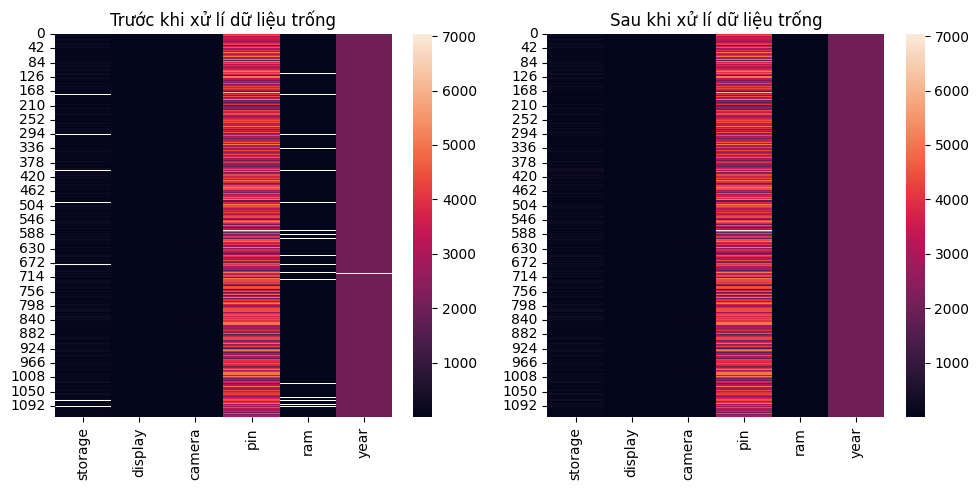

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(df_smallDS[['storage','display','camera','pin','ram','year']],ax=axes[0])
sns.heatmap(df_smallDS_test[['storage','display','camera','pin','ram','year']],ax=axes[1])
axes[0].set_title('Trước khi xử lí dữ liệu trống') 
axes[1].set_title('Sau khi xử lí dữ liệu trống') 
plt.tight_layout()
plt.show()

Xuất ra dữ liệu sau khi đã xử lí trống

In [20]:
df_smallDS_test.to_csv('smallDS_fillnull.csv',index=False) 

## Xử lý outlier

Kiểm tra phân phối của các đặc trưng trước khi xử lí ngoại lệ

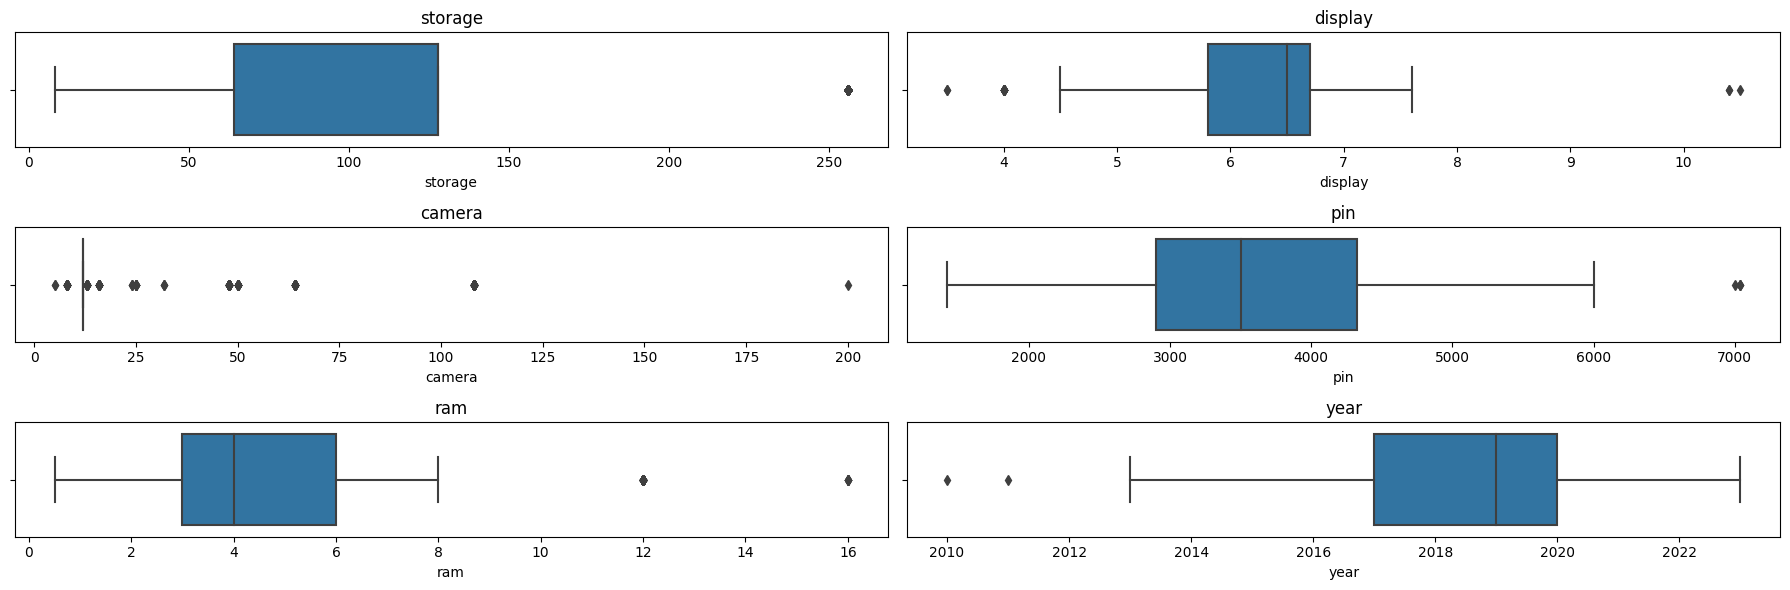

In [21]:
columns_names = ['storage','display','camera','pin','ram','year'] 
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(18,6)) 
for i, column in enumerate(columns_names) : 
    row = i//2
    col = i%2
    ax = axes[row, col] 
    sns.boxplot(x=df_smallDS_test[column],ax=ax) 
    ax.set_title(column) 

plt.tight_layout() 
plt.show()

Sử dụng kĩ thuật xử lí ngoại lệ Skewed

In [22]:
def skewed_outlier_handler(df, column) : 
    q25, q75 = np.percentile(df[column], [25,75]) 
    IQR = q75 - q25
    upper = q75 + 1.5*IQR
    lower = q25 - 1.5*IQR
    df.loc[df[column]>=upper,column] = upper 
    df.loc[df[column]<=lower,column] = lower
    return df

In [23]:
df_smallDS_test = skewed_outlier_handler(df_smallDS_test,'storage') 
df_smallDS_test = skewed_outlier_handler(df_smallDS_test,'display') 
df_smallDS_test = skewed_outlier_handler(df_smallDS_test,'camera') 
df_smallDS_test = skewed_outlier_handler(df_smallDS_test,'pin') 
df_smallDS_test = skewed_outlier_handler(df_smallDS_test,'ram') 
df_smallDS_test = skewed_outlier_handler(df_smallDS_test, 'year')

Phân phối dữ liệu của các đặc trưng sau khi xử lí ngoại lệ

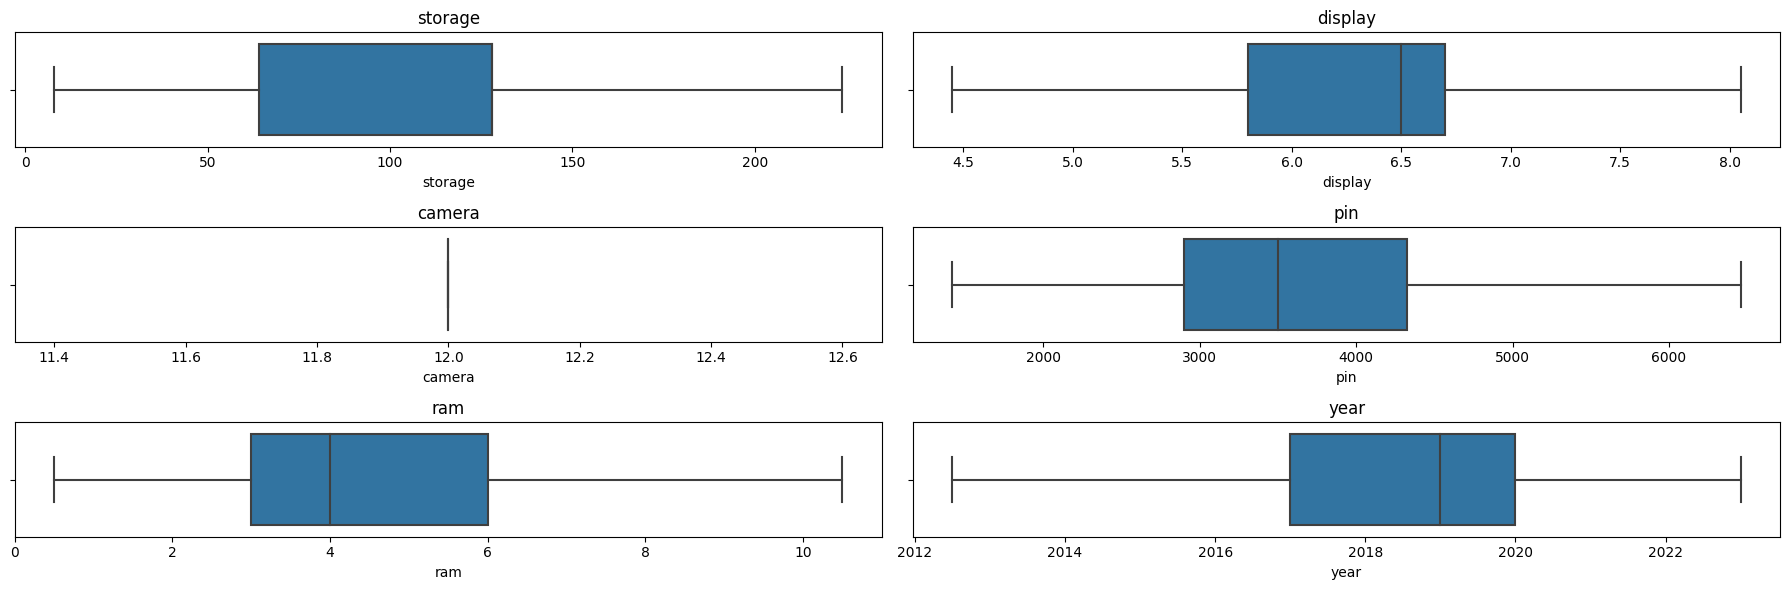

In [24]:
columns_names = ['storage','display','camera','pin','ram','year'] 
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(18,6)) 
for i, column in enumerate(columns_names) : 
    row = i//2
    col = i%2
    ax = axes[row, col] 
    sns.boxplot(x=df_smallDS_test[column],ax=ax) 
    ax.set_title(column) 

plt.tight_layout() 
plt.show()

Xuất ra dữ liệu sau khi đã xử lí ngoại lệ

In [25]:
df_smallDS_test.to_csv('smallDS_outlier.csv',index=False)

## Chuẩn hóa đặc trưng

Đồ thị xác suất trước khi chuẩn hóa

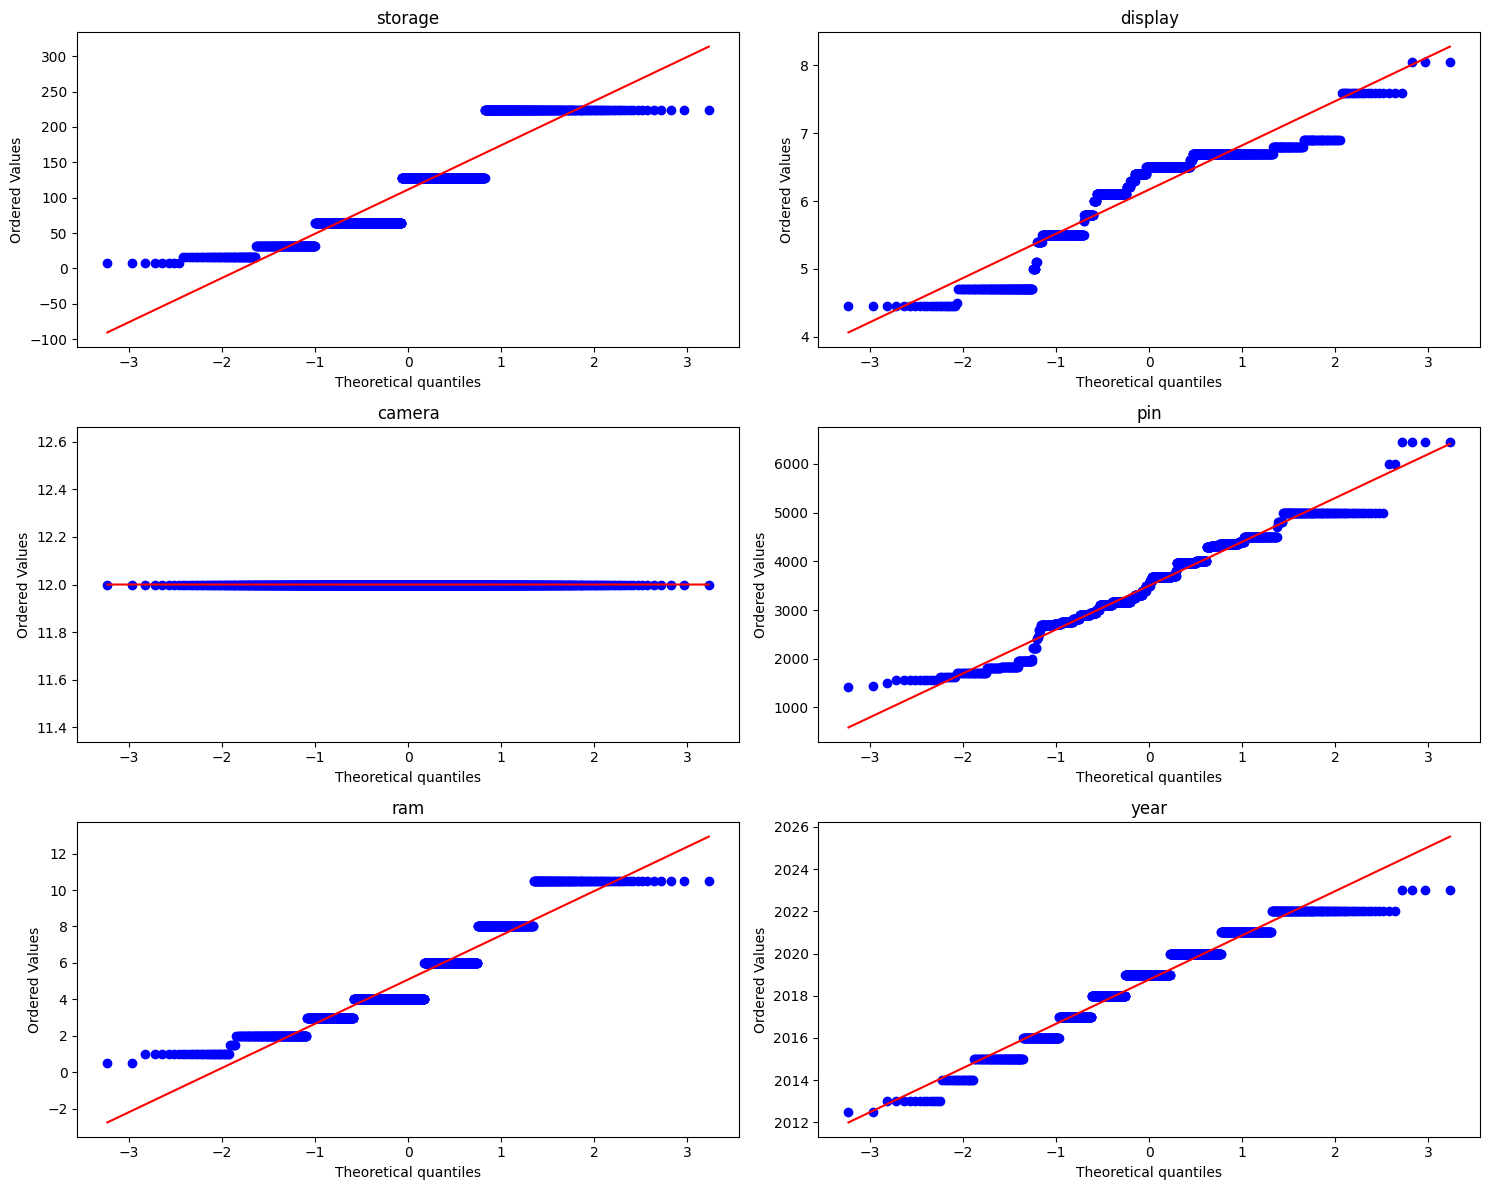

In [26]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(15,12)) 
for i, column in enumerate(columns_names) : 
    row = i//2
    col = i%2
    ax = axes[row, col] 
    stats.probplot(df_smallDS_test[column],dist='norm',plot=ax) 
    ax.set_title(column) 

plt.tight_layout() 
plt.show()

Tiến hành chuẩn hóa đặc trưng sử dụng Normalizer scaler

In [27]:
df_smallDS_normalizer = df_smallDS_test.copy()
df_smallDS_normalizer[['storage','display','camera','pin','ram']] = Normalizer().fit_transform(df_smallDS_normalizer[['storage','display','camera','pin','ram']])
print(df_smallDS_normalizer)

           price  brand               type  condition  preserve   storage  \
0      9900000.0      1      iphone 12 pro          1         0  0.034695   
1      1500000.0      0         galaxy a30          1         0  0.015998   
2      8500000.0      1  iphone 11 pro max          1         0  0.016123   
3     11000000.0      1      iphone 12 pro          1         0  0.034695   
4     16900000.0      0     galaxy z fold3          1         1  0.050843   
...          ...    ...                ...        ...       ...       ...   
1121   7000000.0      1      iphone 8 plus          1         0  0.082952   
1122   6990000.0      0   galaxy s20 ultra          1         0  0.025591   
1123   7500000.0      1          iphone 11          1         0  0.020574   
1124   1500000.0      0     galaxy a6 plus          1         0  0.009142   
1125   1900000.0      0         galaxy a50          0         0  0.015998   

      result   display    camera       pin       ram    year  
0          1

Đồ thị xác suất sau khi đã chuẩn hóa đặc trưng

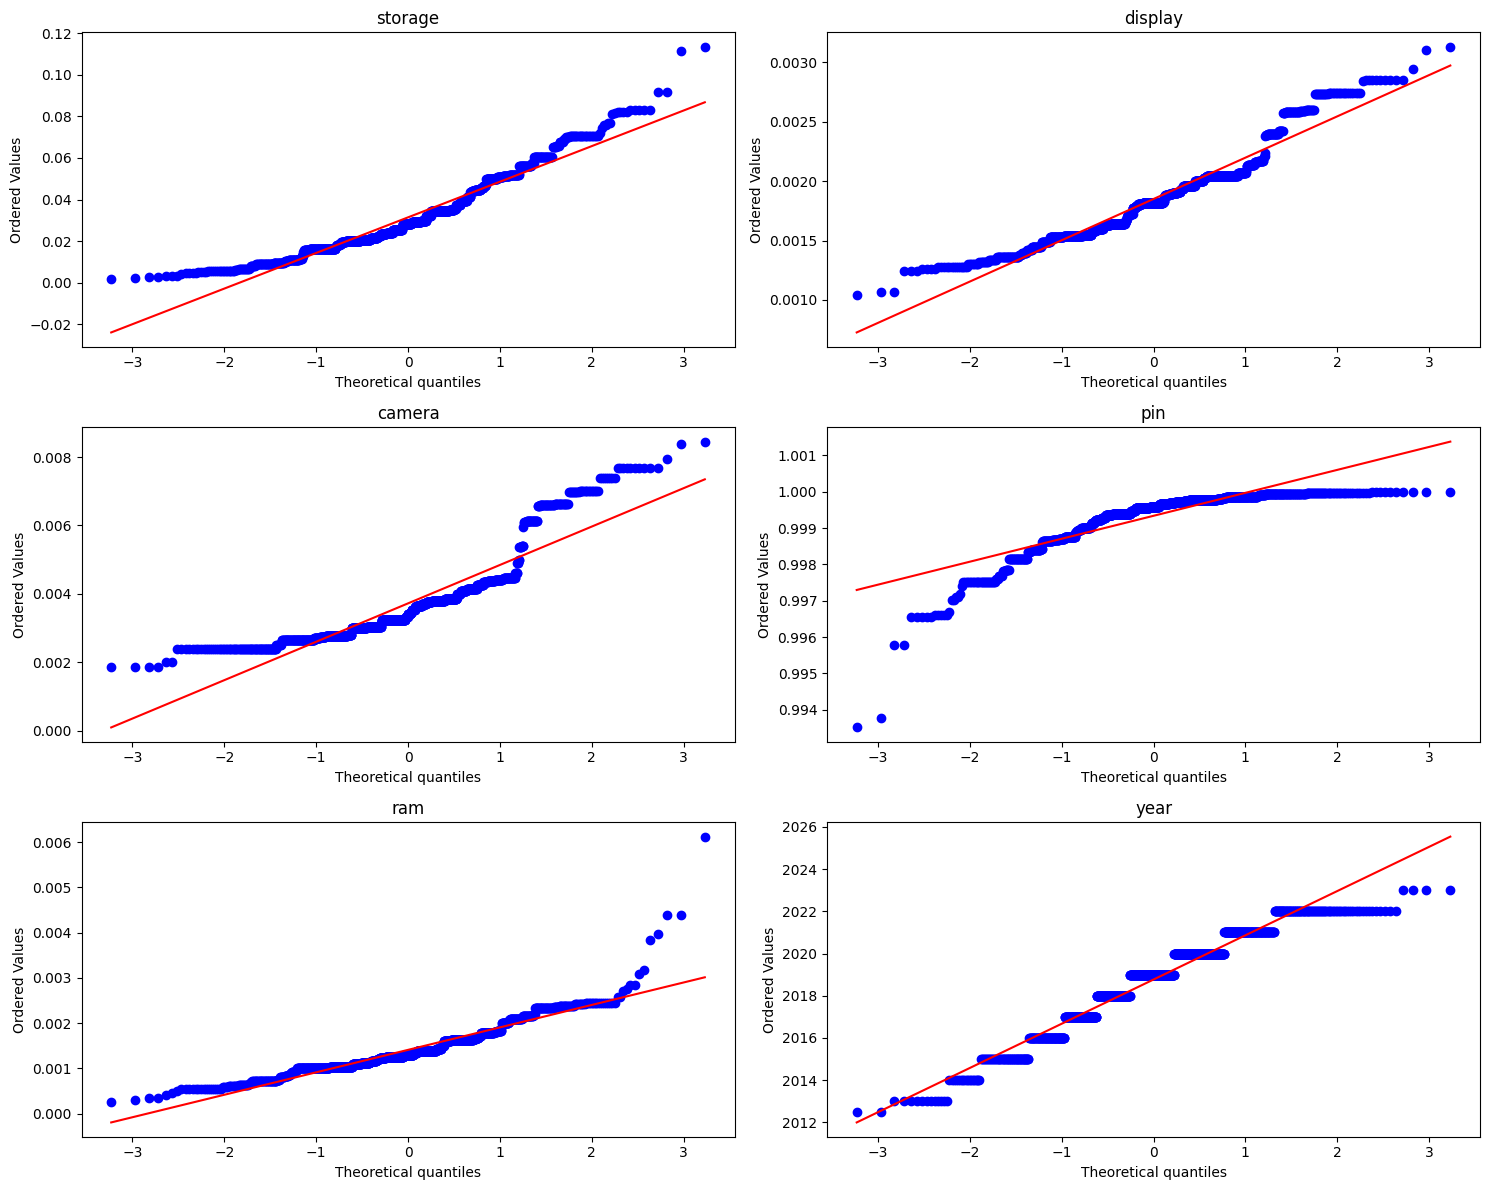

In [28]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(15,12)) 
for i, column in enumerate(columns_names) : 
    row = i//2
    col = i%2
    ax = axes[row, col] 
    stats.probplot(df_smallDS_normalizer[column],dist='norm',plot=ax) 
    ax.set_title(column) 

plt.tight_layout() 
plt.show()

Xuất ra dữ liệu sau khi đã chuẩn hóa

In [29]:
df_smallDS_normalizer.to_csv('smallDS_normalizer.csv',index=False)

In [30]:
print(df_smallDS_normalizer)

           price  brand               type  condition  preserve   storage  \
0      9900000.0      1      iphone 12 pro          1         0  0.034695   
1      1500000.0      0         galaxy a30          1         0  0.015998   
2      8500000.0      1  iphone 11 pro max          1         0  0.016123   
3     11000000.0      1      iphone 12 pro          1         0  0.034695   
4     16900000.0      0     galaxy z fold3          1         1  0.050843   
...          ...    ...                ...        ...       ...       ...   
1121   7000000.0      1      iphone 8 plus          1         0  0.082952   
1122   6990000.0      0   galaxy s20 ultra          1         0  0.025591   
1123   7500000.0      1          iphone 11          1         0  0.020574   
1124   1500000.0      0     galaxy a6 plus          1         0  0.009142   
1125   1900000.0      0         galaxy a50          0         0  0.015998   

      result   display    camera       pin       ram    year  
0          1

## Lựa chọn đặc trưng

In [31]:
# Tính ma trận tự tương quan
correlation_matrix = df_smallDS_normalizer.corr()

# Đặt ngưỡng tương quan
threshold = 0.2

# Lựa chọn đặc trưng
selected_features = []
for feature in correlation_matrix:
    if feature == 'price':
        continue
    if abs(correlation_matrix['price'][feature]) > threshold:
        selected_features.append(feature)

# In ra các đặc trưng được lựa chọn
print(selected_features)

['brand', 'preserve', 'storage', 'display', 'camera', 'pin', 'ram', 'year']


C:\Users\HP\AppData\Local\Temp\ipykernel_16420\1994225620.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_smallDS_normalizer.corr()


Xuất ra dữ liệu với các đặc trưng được chọn

In [32]:
df_smallDS_normalizer.to_csv('smallDS_FTselection.csv',columns=['price']+selected_features, index=False) 

Heatmap ma trận tương quan giữa các đặc trưng

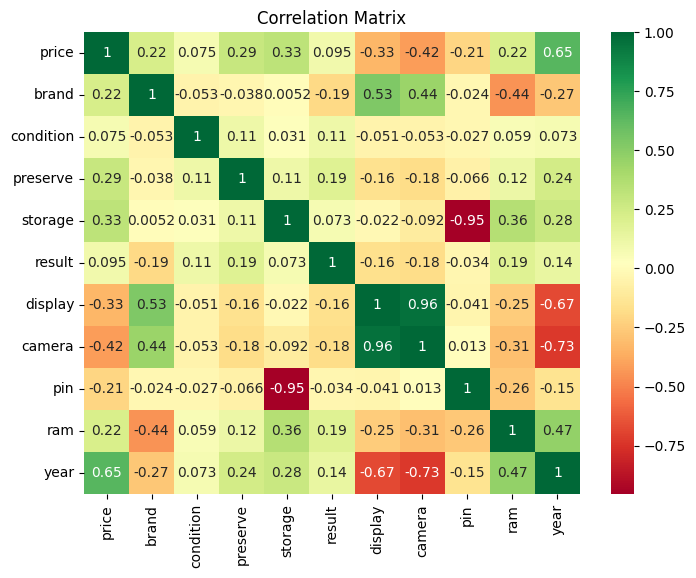

In [33]:
plt.figure(figsize=(8,6)) 
# first_row_df = pd.DataFrame(correlation_matrix.iloc[0]).T
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn') 
plt.title('Correlation Matrix') 
plt.show() 